# Hidden Markov Models

In this notebook, we'll implement and assess a simple HMM. To do so, we'll use the `hmmlearn` package. There is more information in [the hmmlearn tutorial](https://hmmlearn.readthedocs.io/en/latest/tutorial.html).

In [3]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

## Example #1: Weather prediction

### Step 1: Define our model

In this example, The state space is defined as a state which is a list of two possible weather conditions: “Sunny” and “Rainy”. The observation space is defined as observations which is a list of two possible observations: “Dry” and “Wet”. The number of hidden states and the number of observations are defined as constants.

The start probabilities, transition probabilities, and emission probabilities are defined as arrays. **The start probabilities** represent the probabilities of starting in each of the hidden states, the **transition probabilities** represent the probabilities of transitioning from one hidden state to another, and the **emission probabilities** represent the probabilities of observing each of the outputs given a hidden state.

In [4]:
# Define states & observations
states = ['Sunny', 'Rainy']

# Define the observation space
observations = ['Dry', 'Wet']

# Define the initial state distribution
state_probability = np.array([0.6, 0.4])

# Define the state transition probabilities
transition_probability = np.array([[0.7, 0.3],[0.3, 0.7]])

# Define the observation likelihoods
emission_probability= np.array([[0.9, 0.1],[0.2, 0.8]])

Number of hidden states : 2
Number of observations : 2


### Step 2: Train the model
The HMM model is defined using the `hmm.CategoricalHMM` class from the hmmlearn library. An instance of the CategoricalHMM class is created with the number of hidden states set to `n_states` and the parameters of the model are set using the `startprob_`, `transmat_`, and `emissionprob_` attributes to the state probabilities, transition probabilities, and emission probabilities respectively.

In [9]:
model = hmm.CategoricalHMM(n_components=len(states))
model.startprob_ = state_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probability

### Step 3: Decode

With our model now setup, we can create a list of observations and decode it.

A sequence of observations is defined as a one-dimensional NumPy array. The observed data is defined as `observations_sequence` which is a sequence of integers, representing the corresponding observation in the observations list.

In [7]:
# Define the sequence of observations
observations_sequence = np.array([0, 1, 0, 1, 0, 0]).reshape(-1, 1)
observations_sequence

array([[0],
       [1],
       [0],
       [1],
       [0],
       [0]])

Below, the Viterbi algorithm is used to calculate the most likely sequence of hidden states that generated the observations using the decode method of the model. The method returns the log probability of the most likely sequence of hidden states and the sequence of hidden states itself. Log probability isn't particularly useful in itself but can be used to compare models -- like non-log probability, higher is better.

In [10]:
# Predict the most likely sequence of hidden states
hidden_states = model.predict(observations_sequence)
print("Most likely hidden states:", hidden_states)

# Decode
log_probability, hidden_states = model.decode(observations_sequence, 
                                              lengths = len(observations_sequence), 
                                              algorithm ='viterbi' )

print('Log Probability :',log_probability)

Most likely hidden states: [0 1 1 1 0 0]
Log Probability : -6.360602626270058


<div class="alert alert-success"><b>Tasks</b>: Modify the code above to match the transition probabilities described in the lecture slides.    
</div>

## Example #2: Dishonest casino

We suspect that a casino is trading out a fair die (singular or dice) for a loaded die. We want to figure out 1) when the loaded die was used (i.e. the most likely path) 2) how often the loaded die is used (i.e. the transition probabilities) and 3) the probabilities for each outcome of a roll for the loaded die (i.e. the emission probabilities).

First, we'll act as the casino and exchange a fair die for a loaded one and generate a series of rolls that someone at the casino would observe. If we have a fair die, we'll have a 95% chance of continuing to use it, but a 5% chance to switch. In the loaded die state, we have a 90% chance of staying and a 10% chance of leaving.

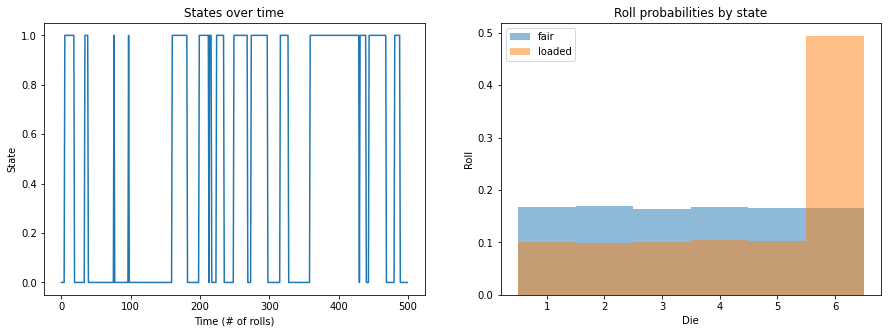

In [33]:
# make our generative model with two components, a fair die and a loaded die
gen_model = hmm.CategoricalHMM(n_components=2)

gen_model.startprob_ = np.array([1.0, 0.0])

gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])

# the first state is a fair die with equal probabilities and the
# second is loaded by being biased toward rolling a six
gen_model.emissionprob_ = \
    np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],
              [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 2]])

# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(30000)

# plot states over time, let's just look at the first 500 rolls
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(gen_states[:500])
ax[0].set_title('States over time')
ax[0].set_xlabel('Time (# of rolls)')
ax[0].set_ylabel('State')

# plot rolls for the fair and loaded states
ax[1].hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax[1].hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax[1].set_title('Roll probabilities by state')
ax[1].set_xlabel('Die')
ax[1].set_xticks(ticks=[0,1,2,3,4,5],labels=['1','2','3','4','5','6'])
ax[1].set_ylabel('Roll')
ax[1].legend()
plt.show()

Now we'll train and decode, seeing if we can recover our hidden states, transmission matrix and emission probabilities.

Model #0	Score: -26192.686320731424
Model #1	Score: -26325.519153251287
Model #2	Score: -26247.37450144936
Model #3	Score: -26186.69051567507
Model #4	Score: -26198.92880039691
Model #5	Score: -26180.251318807237
Model #6	Score: -26219.376180428026
Model #7	Score: -26182.606841632427
Model #8	Score: -26228.56673432129
Model #9	Score: -26219.247899254307
Generated score: -26175.4414621326
Best score:      -26180.251318807237


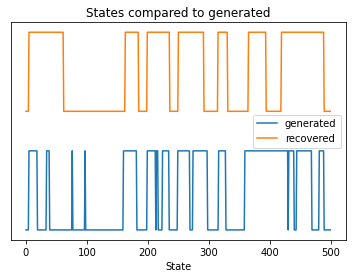

In [34]:
# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

# check optimal score
gen_score = gen_model.score(X_validate)

best_score = best_model = None
n_fits = 10

for idx in range(n_fits):
    model = hmm.CategoricalHMM(n_components=2, random_state=idx, init_params='se')

    model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])
    
    model.fit(X_train)
    score = model.score(X_validate)
    
    print(f'Model #{idx}\tScore: {score}')
    
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Generated score: {gen_score}\nBest score:      {best_score}')

# predict the most likely sequence of states given the model
states = best_model.predict(rolls)

# plot our recovered states compared to generated
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()
plt.show()

Let’s check our learned transition probabilities and see if they match.

In [25]:
print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n\n')

Transmission Matrix Generated:
[[0.95 0.05]
 [0.1  0.9 ]]

Transmission Matrix Recovered:
[[0.939 0.061]
 [0.101 0.899]]




Finally, let’s see if we can tell how the die is loaded.

In [26]:
print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n\n')

Emission Matrix Generated:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.1   0.1   0.1   0.1   0.1   0.5  ]]

Emission Matrix Recovered:
[[0.16  0.17  0.168 0.173 0.171 0.157]
 [0.116 0.106 0.112 0.092 0.1   0.474]]




In this case, we were able to get very good estimates of the transition and emission matrices, but decoding the states was imperfect. That’s because the decoding algorithm is greedy and picks the most likely series of states which isn’t necessarily what happens in real life. Even so, our model could tell us when to watch for the loaded die and we’d have a better chance at catching them red-handed.

<div class="alert alert-success"><b>Task</b>: Modify the code above for a hypothetical coffee --> water --> alcohol example.
    
</div>

## About this notebook
This notebook is largely based on the examples in [Geeks for Geeks](https://www.geeksforgeeks.org/hidden-markov-model-in-machine-learning/) and the [hmmlearn tutorial](https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_casino.html).